## Introduction to the GLM

Now that the data is clean we can perform analysis. Resting state analysis is completed in notebook 6. This is a review of the general linear model using data that was collected during a breathholding task. 

### Step 1: Ensure you have data from the breath-hold task downloaded to your local machine. 
    
Run the following command in terminal to grab all the fmriprep func data for the sub-10788.

`cat download_list |   xargs -I '{}' aws s3 sync --no-sign-request   s3://openneuro/ds000030/ds000030_R1.0.5/uncompressed/{}/func   ./data/ds000030/{}/func   --exclude '*'   --include '*sub-10788*' `
    
### Step 2: We need to figure out the stimulus for the breath holding task. 

The description of this task is contained in `data/ds000030/task-bht_bold.json`. This does not give precise timing but luckily those are included in the table below:

| Parameter     |  Time (Seconds)      | 
| :-------------: | :-------------: | 
| Rest Time     | 16.5 |
| Activation Time     | 13.5 |
| Block Length     | 30 |
| Scan Time | 150      |
| Repetition Time | 2      |

/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


Text(0.5, 1.0, 'Breath hold activation')

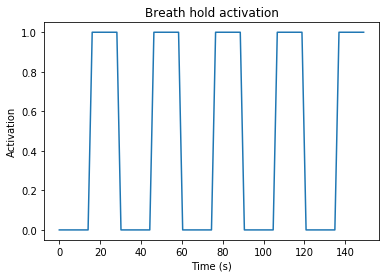

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

rest_time = 16.5
act_time = 13.5
block_time = act_time+rest_time
total_time = 150
TR=2
blocks = total_time/block_time

times = np.linspace(0, total_time-1, total_time/TR)
block_regressor = np.concatenate((np.zeros(int(np.round(rest_time/TR))), np.ones(int(np.round(act_time/TR)))))
task_regressor = np.tile(block_regressor, int(blocks))

plt.plot(times,task_regressor)
plt.xlabel('Time (s)')
plt.ylabel('Activation')
plt.title('Breath hold activation')

### Step 3: Now that we know what stimulus was used we need to convolve it with a hemodynamic response function. 

This can be done using using the nipy.modalities.fmri.hrf.spmt function. 

Text(0.5, 0, 'Time (s)')

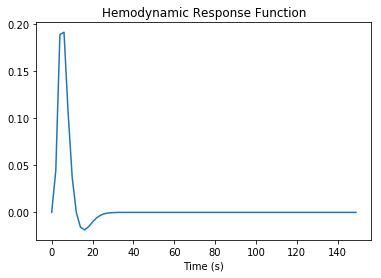

In [29]:
from nipy.modalities.fmri.hrf import spmt

hrf = spmt(times)
plt.plot(times, hrf)
plt.title('Hemodynamic Response Function')
plt.xlabel('Time (s)')

This HRF response is in TR just like of `task_regressor`. We can now convolve and plot them using np.convolve().

Text(0.5, 0, 'Time (s)')

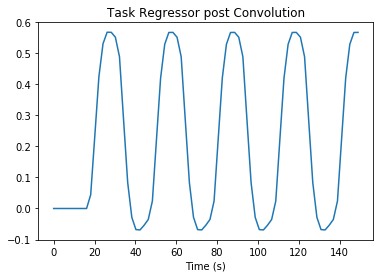

In [30]:
task_convolved = np.convolve(task_regressor, hrf)[0:len(times)]
plt.plot(times,np.convolve(task_regressor, hrf)[0:len(times)])
plt.title('Task Regressor post Convolution')
plt.xlabel('Time (s)')

### Step 4: Now can we fit the fmri data 

Let's do the simplest example first and look at the results. We can then use confounds and pre-whitening to improve our fit. We want to perform a linear regression between our expected timeseris anf every voxel's timeseries in our region of interest (aka the brain).

Loaded image shape:  (64, 88, 66, 79)
Masked image shape:  (79, 39076)


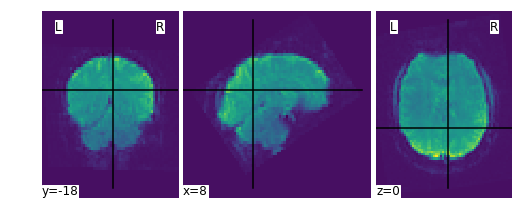

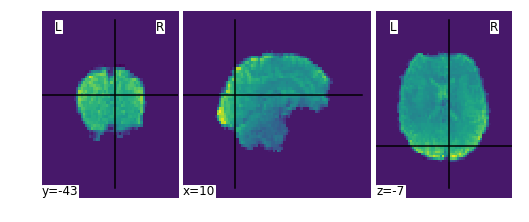

In [57]:
import nibabel as nb
from nilearn import plotting as plot
from nilearn import image as img
from nilearn.input_data import NiftiMasker

mask_filename='../data/ds000030/derivatives/fmriprep/sub-10788/func/sub-10788_task-bht_bold_space-T1w_brainmask.nii.gz'
epi_filename='../data/ds000030/derivatives/fmriprep/sub-10788/func/sub-10788_task-bht_bold_space-T1w_preproc.nii.gz'

epi_data = img.load_img(epi_filename)
print("Loaded image shape: ",epi_data.shape)
mask_data = img.load_img(mask_filename)

# Let's look at the epi like we did in NB #4
plot.plot_img(epi_data.slicer[:,:,:,0])

# Let's also look at it masked
masked_func = img.math_img('a*b',a=epi_data.slicer[:,:,:,0],b=mask_data)
plot.plot_img(masked_func)

# Use NiftiMasker to mask whole EPI series and transform it into something we can fit
nifti_masker = NiftiMasker(
    smoothing_fwhm=0,
    mask_img=mask_filename,
    memory='nilearn_cache', memory_level=1)

epi_data=nifti_masker.fit_transform(epi_filename)
print("Masked image shape: ", epi_data.shape)

# Now our data is in timepoints by voxels form, lets remove the first four volumes (they are dummy scans)
epi_data = epi_data[4:,:]



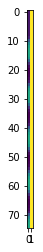

In [56]:
# Our design matrix right now is just our regressor. Let's add an offset so our fit is: Y = AX+B
# This will account for mean intensity changes

X = np.stack((task_convolved, np.ones_like(task_convolved)),axis=1)
plt.figure()
plt.imshow(X)



/Users/oliviastanley/miniconda3/envs/conpcourse/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


(64, 88, 66)


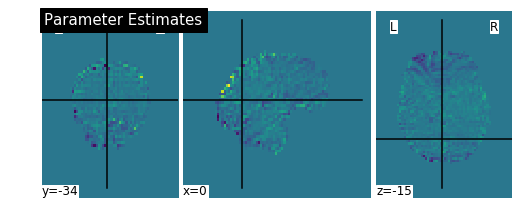

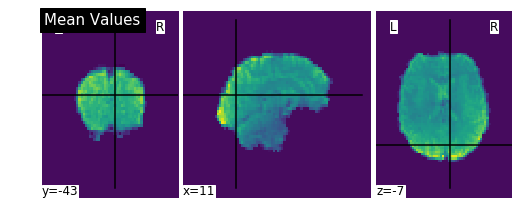

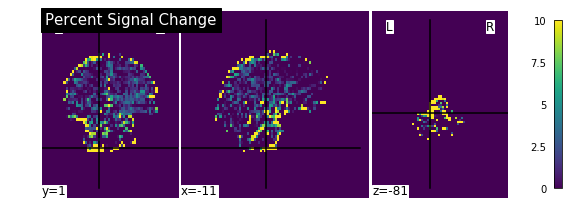

In [63]:
# now we can fit it using a simple least squares regression and map it back to epi space
param_ests, res, _, _=np.linalg.lstsq(X, epi_data)

print(param_est.shape)
activation = nifti_masker.inverse_transform(param_ests[0,:])
plot.plot_img(activation, title="Parameter Estimates")
mean_val = nifti_masker.inverse_transform(param_ests[1,:])
plot.plot_img(mean_val,title="Mean Values")
percent_change = nifti_masker.inverse_transform(100*param_ests[0,:]/param_ests[1,:])
plot.plot_img(percent_change, colorbar=True, vmin=0, vmax=10, title="Percent Signal Change")


### Step 4: Now we can fit our model of what task was acquired to our input data

This can be done using the permuted ols function from nilearn. We can also include motion confounds as before simulataneously in order to remove them during fitting opposed to cleaning the data. This is the standard for task based data.

### Step 5: Visualizing fit results

Now to visualize the results of our fit. Lets look at a plot of the most active voxel and a show an image of estimates beta weights.

We can also look at the residuals across space and time. These can show issues such as motion or physiology contamination.

### Step 6: Improving our fit with confound regressors and pre-whitening

The OLS fit we ran before did not take into account the covariance of our data. 

### Step 7: Wrapping up and Final Thoughts